In [1]:
#Project Imported libs 
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

8792 8968
(64, 64, 3)


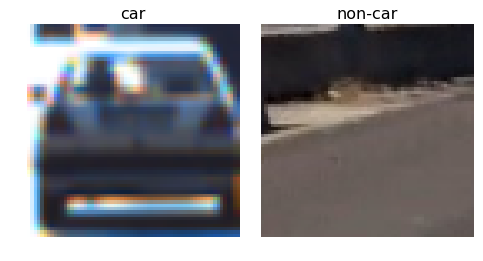

In [2]:
#load car and non-car images 
car_images = glob.glob('./vehicles/**/*.png')
noncar_images = glob.glob('./non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

#print example of the car loaded images and the non-car loaded images 
fig, axs = plt.subplots(1,2, figsize=(8, 8))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

# show a car image
img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
axs[0].axis('off')
axs[0].set_title('car', fontsize=16)
axs[0].imshow(img)
print(img.shape)

# show a non-car image
img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
axs[1].axis('off')
axs[1].set_title('non-car', fontsize=16)
axs[1].imshow(img)

In [3]:
###############################extracting HOG features################################################################ 
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

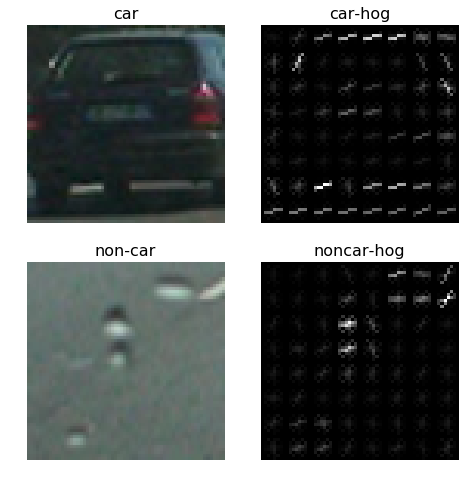

In [4]:
#visualizing HOG feature on random car & non-car image
fig, axs = plt.subplots(2,2, figsize=(8, 8))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

# show a car image
car_img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
axs[0].axis('off')
axs[0].set_title('car', fontsize=16)
axs[0].imshow(car_img)
car_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
feat, car_hog = get_hog_features(car_gray, 9, 8, 2, vis=True, feature_vec=True)
axs[1].axis('off')
axs[1].set_title('car-hog', fontsize=16)
axs[1].imshow(car_hog, cmap ='gray')

# show a non-car image
noncar_img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
axs[2].axis('off')
axs[2].set_title('non-car', fontsize=16)
axs[2].imshow(noncar_img)

noncar_gray = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)
feat, noncar_hog = get_hog_features(noncar_gray, 9, 8, 2, vis=True, feature_vec=True)
axs[3].axis('off')
axs[3].set_title('noncar-hog', fontsize=16)
axs[3].imshow(noncar_hog, cmap ='gray')

In [5]:
# Define a function to extract HOG features from a list of images
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
################################Extract Features vector for the Car and Non-car Images############################
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


56.5 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [7]:
################################Train linear SVM classifier##########################################################
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9817
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  0.  1.]
For these 20 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  1.  1.]
0.02 Seconds to predict 20 labels with SVC


In [8]:
###############Searching window to find cars in an image using the trained classifier traiend above##################

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop,xstart,xstop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
            hog_features = hog_features.reshape(1,-1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [9]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Number of detection boxes 5


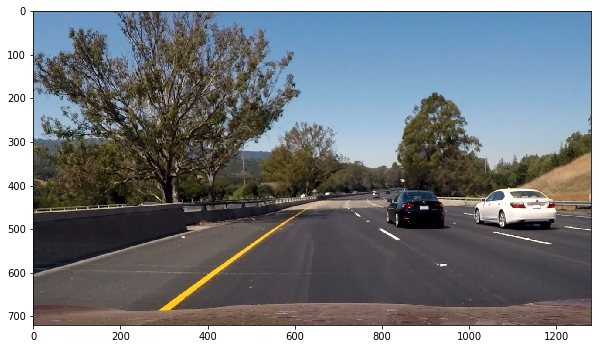

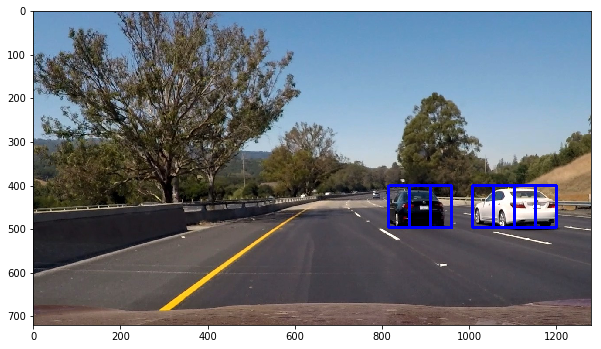

In [25]:
#Test find cars functions using test images and draw the detection boxes using draw boxes func.
test_img = mpimg.imread('./test_images/test6.jpg')
plt.figure(figsize=(10,10))
plt.imshow(test_img)

#define the region of interest for searching for cars 
ystart = 400
ystop = 640
xstart = 0
xstop = test_img.shape[1]

#define window scale factor
scale = 1.5

boxes = find_cars(test_img, ystart, ystop,xstart,xstop, scale,colorspace,'ALL', svc,None, orient,
                  pix_per_cell, cell_per_block, None, None, False)

box_img = draw_boxes(test_img , boxes)

plt.figure(figsize=(10,10))
plt.imshow(box_img)

print('Number of detection boxes',len(boxes))


Number of detection boxes 44
Number of detection boxes 38
Number of detection boxes 28
Number of detection boxes 20
Number of detection boxes 3


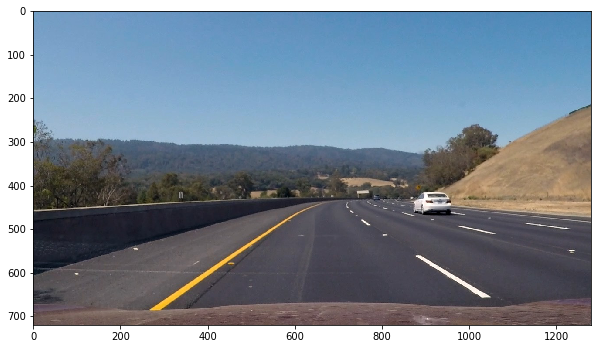

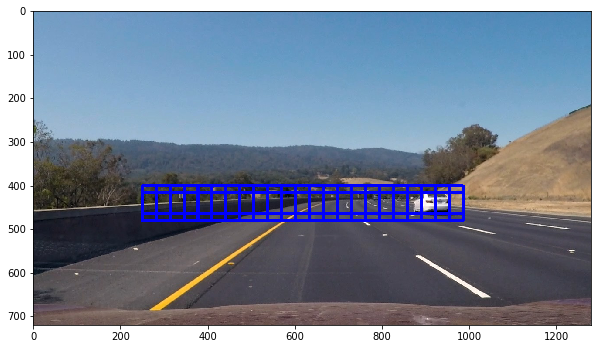

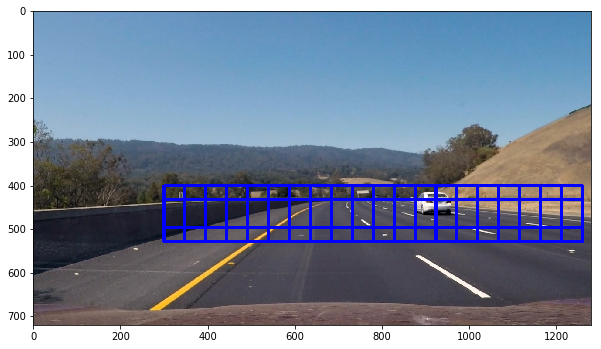

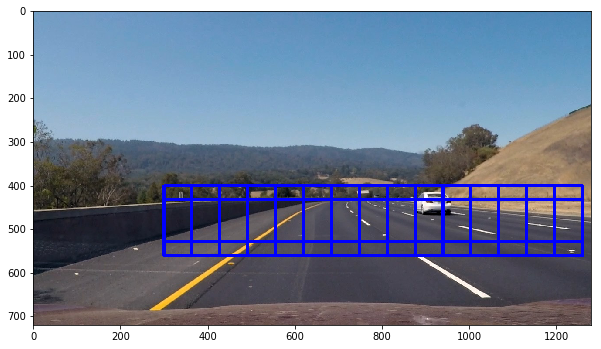

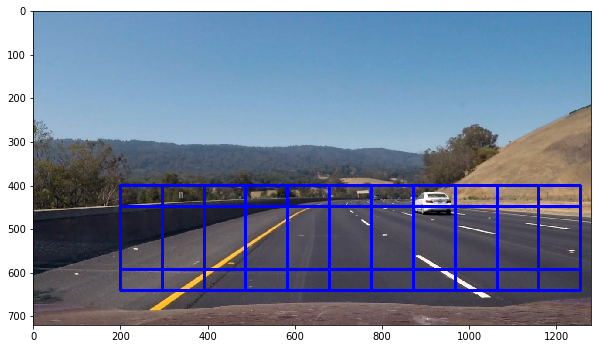

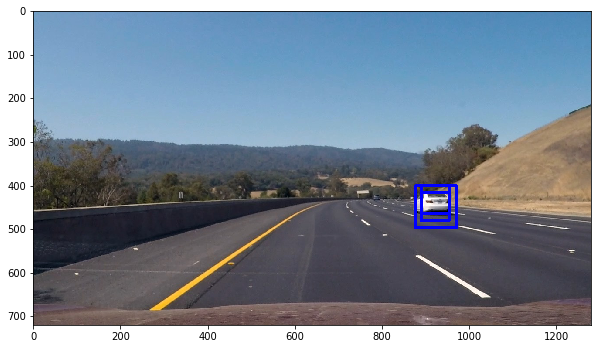

In [11]:
################Defining Multi scale windows and test on one of the test images #############################
#array of list define the multi scale windows 
#list elements : scale,x_start,x_stop,y_start,y_stop
multi_scale_win = [[1,250,1000,400,464],[1,250,1000,416,480],[1.5,300,1300,400,496],[1.5,300,1300,432,528],
                   [2,300,1300,400,528],[2,300,1300,432,560],[3,200,1300,400,592],[3,200,1300,448,640]] 

test_img = mpimg.imread('./test_images/test3.jpg')
plt.figure(figsize=(10,10))
plt.imshow(test_img)
imcopy = np.copy(test_img)

rect = []
allboxes = []
i = 0
for scale in multi_scale_win:
    
    allboxes.append(find_cars(test_img, scale[3],scale[4],scale[1],scale[2], scale[0],colorspace,'ALL', svc,None, orient,
                  pix_per_cell, cell_per_block, None, None, True))
    
    rect.append(find_cars(test_img, scale[3],scale[4],scale[1],scale[2], scale[0],colorspace,'ALL', svc,None, orient,
                  pix_per_cell, cell_per_block, None, None, False))
    
    i = i +1
    
    if(i%2 == 0):
        
        allboxes = [item for sublist in allboxes for item in sublist]
        box_img = draw_boxes(test_img , allboxes)

        plt.figure(figsize=(10,10))
        plt.imshow(box_img)

        print('Number of detection boxes',len(allboxes))
        
        allboxes = []


#plot the detection using the multi-scale window

rect = [item for sublist in rect for item in sublist]

detection_img = draw_boxes(test_img , rect)

plt.figure(figsize=(10,10))
plt.imshow(detection_img)

print('Number of detection boxes',len(rect))
    
    
    
    



In [12]:
#Add Heat Map to handle false positivies 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

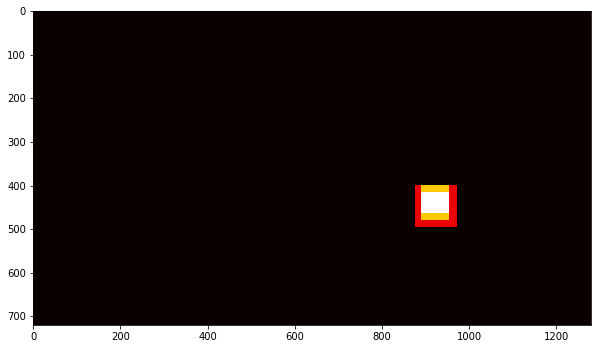

In [13]:
#test heatmap function 
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rect)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [14]:
##Apply Threshold on the heatmap output
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

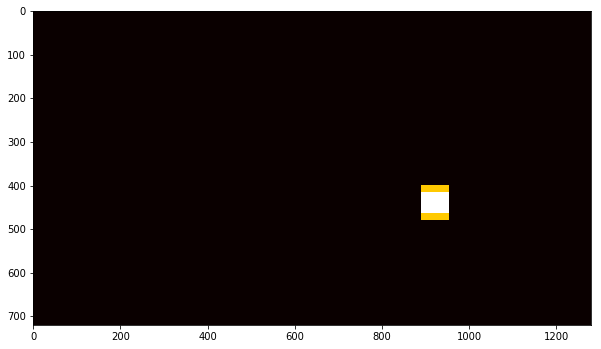

In [15]:
#test the threshold func 
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [16]:
#draw labled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

1 cars found


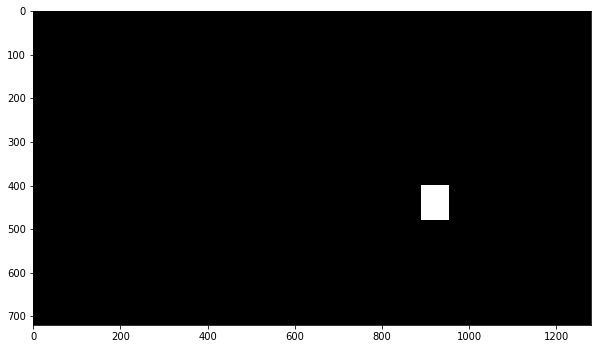

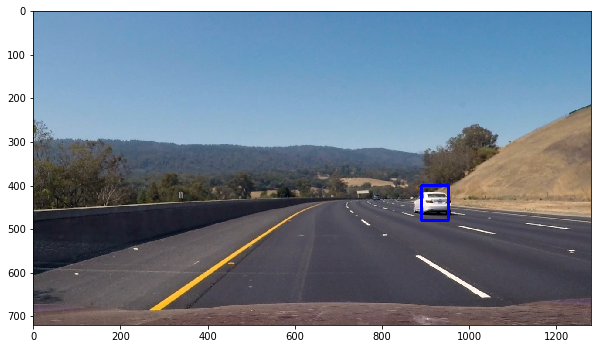

In [17]:
#test label func
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [18]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [19]:
#tracking pipeline 
def VehTrackingProcessImage(img,det_obj):
    
    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    
    #define the region of interest for searching for cars(Multi scale window searching area)
    #list elements order : scale , x_start, x_stop , y_start , y_stop
    multi_scale_win = [[1,250,1000,400,464],[1,250,1000,416,480],[1.5,300,1300,400,496],[1.5,300,1300,432,528],
                   [2,300,1300,400,528],[2,300,1300,432,560],[3,200,1300,400,592],[3,200,1300,448,640]]
    
    for scale in multi_scale_win:
        
        rectangles.append(find_cars(img, scale[3],scale[4],scale[1],scale[2], scale[0],colorspace,hog_channel, svc,
                                    None, orient,pix_per_cell, cell_per_block, None, None, False))
        
    rectangles = [item for sublist in rectangles for item in sublist]
    
    heatmap_img = np.zeros_like(img[:,:,0])
        
    if(det_obj != None):
          # add detections to the history
        if len(rectangles) > 0:
            det_obj.add_rects(rectangles)
    
        for rect_set in det_obj.prev_rects:
            heatmap_img = add_heat(heatmap_img, rect_set)
        
        heatmap_img = apply_threshold(heatmap_img, 1 + len(det_obj.prev_rects)//2)
    else:
        heatmap_img = add_heat(heatmap_img, rectangles)
        heatmap_img = apply_threshold(heatmap_img, 1)
    
    labels = label(heatmap_img)
    
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img
    
    
    

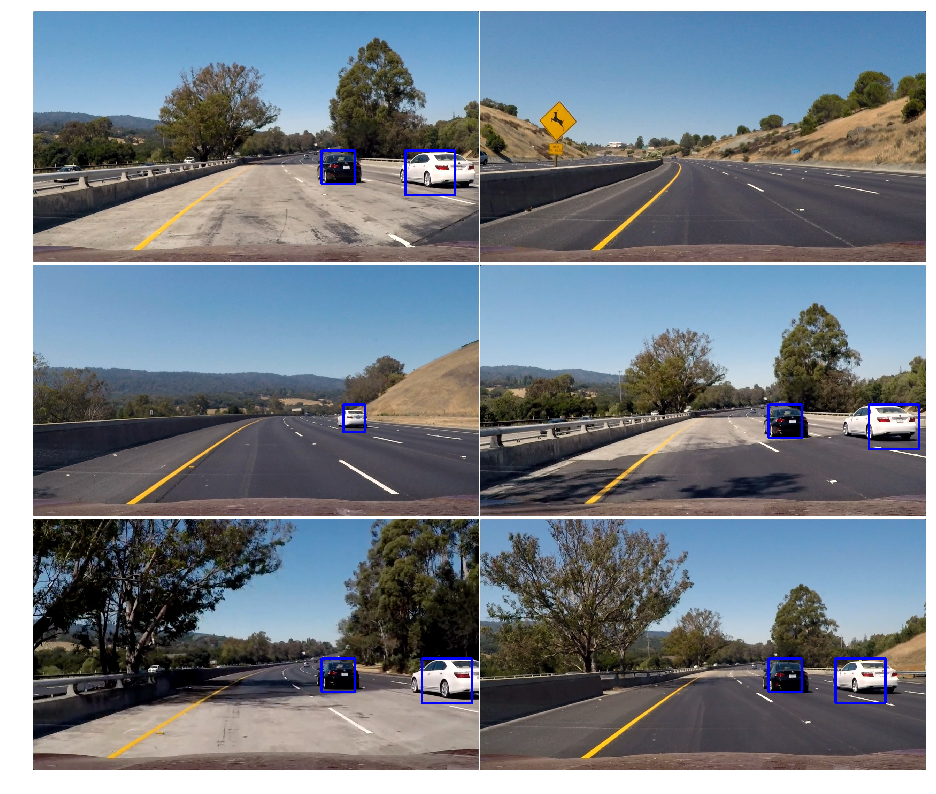

In [20]:
#test pipeline using the test images
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(VehTrackingProcessImage(mpimg.imread(im),None))
    axs[i].axis('off')

In [21]:
#The callout func. that will be called while the video frame processing , This fun will call the pipeline processing function
#but with passing the vehicle detection object 
det1  = Vehicle_Detect()
def VideoProcessing(img):
    ret_img = VehTrackingProcessImage(img,det1)
    return ret_img

#Test Pipeline of test video 
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')

clip_test_out = clip_test.fl_image(VideoProcessing)
%time clip_test_out.write_videofile(test_out_file, audio=False)

In [23]:
#execute pipeline over project video
det2  = Vehicle_Detect()
def ProjectVideoProcessing(img):
    ret_img = VehTrackingProcessImage(img,det2)
    return ret_img

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')#.subclip(0,2)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(ProjectVideoProcessing)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:51<00:00,  4.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 4min 52s
